In [1]:
%pylab inline
%config InlineBackend.figure_format='retina'
import seaborn
import networkx
from grave import grave
from SuchTree import SuchTree, SuchLinkedTrees
import pandas
import cartopy.crs
from cartopy.io.img_tiles import OSM
#from geopy.geocoders import Nominatim
#from geopy.distance import geodesic
from scipy.cluster import hierarchy
import screed
#import os
import pyprind

Populating the interactive namespace from numpy and matplotlib


In [25]:
metadata = pandas.read_csv( 'data/Table1_5_combined.txt', sep='\t', 
                      dtype={'Body_site':str, 'POGs_SUBFAMILY':str} )

# fix capitalization inconsistencies
metadata.Habitat = metadata.Habitat.apply( lambda x : x.lower() )

metadata.head()

,UViG,TAXON_OID,Scaffold_ID,VIRAL_CLUSTERS,Ecosystem,Ecosystem_Category,Ecosystem_Type,Ecosystem_Subtype,Habitat,Body_site,...,Host,Host_detection,Host_domain,Estimated_completeness,Quality,POGs_ORDER,POGs_FAMILY,POGs_SUBFAMILY,POGs_GENUS,putative_retrovirus
0,2003000007_____2003296998,2003000007,2003296998,sg_24096,Environmental,Air,Outdoor Air,0,air,NaN,...,NaN,NaN,Bacteria,NaN,Genome_fragment,NaN,NaN,NaN,NaN,NaN
1,2003000007_____2003297061,2003000007,2003297061,sg_24097,Environmental,Air,Outdoor Air,0,air,NaN,...,NaN,NaN,Bacteria,NaN,Genome_fragment,NaN,NaN,NaN,NaN,NaN
2,2003000007_____2003297087,2003000007,2003297087,sg_24098,Environmental,Air,Outdoor Air,0,air,NaN,...,NaN,NaN,Bacteria,NaN,Genome_fragment,NaN,NaN,NaN,NaN,NaN
3,2003000007_____2003297164,2003000007,2003297164,sg_24099,Environmental,Air,Outdoor Air,0,air,NaN,...,NaN,NaN,Bacteria,NaN,Genome_fragment,NaN,NaN,NaN,NaN,NaN
4,2003000007_____2003297262,2003000007,2003297262,sg_24100,Environmental,Air,Outdoor Air,0,air,NaN,...,NaN,NaN,NaN,NaN,Genome_fragment,NaN,NaN,NaN,NaN,NaN


In [3]:
lastal_cols = [ 'query_id', 'subject_id', 'identity', 'alignment_length',
                'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start',
                's_end', 'evalue', 'bitscore', 'query_length', 'subject_length',
                'raw_score' ]

isomags = pandas.read_csv( 'data/spacers_vs_all_viral_sequences_combined_v2_Filtered_1Snp_100AF.lout', 
                      sep='\t', names=lastal_cols, index_col=False )

isomags.head()

,query_id,subject_id,identity,alignment_length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue,bitscore,query_length,subject_length,raw_score
0,637000024:NC_003228:2:2998261,7000000526_____SRS019397_WUGC_scaffold_4145,100.00,34,0,0,34,1,22441,22474,1.400000e-08,55.3,34,47940,34
1,637000024:NC_003228:2:2998455,7000000526_____SRS019397_WUGC_scaffold_4145,97.06,34,1,0,1,34,22655,22688,2.500000e-07,52.2,34,47940,32
2,637000024:NC_003228:3:4661323,3300007975_____Ga0114169_100414,96.67,30,1,0,30,1,1397,1426,3.200000e-05,45.9,30,20299,28
3,637000024:NC_003228:3:4661323,7000000131_____C1053521,96.67,30,1,0,1,30,29086,29115,3.200000e-05,45.9,30,30419,28
4,637000024:NC_003228:3:4661400,3300006487_____Ga0100256_10099,100.00,30,0,0,30,1,44872,44901,1.800000e-06,49.0,30,60085,30


In [4]:
metaspacers = pandas.read_csv( 'data/imgvr/meta_spacers_vs_imgvr_filtered.lout',
                               sep='\t', names=lastal_cols[:-1], index_col=False, skiprows=1 )

metaspacers.head()

,query_id,subject_id,identity,alignment_length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue,bitscore,query_length,subject_length
0,2001200001:2001262804:1:1120,3300006255_____Ga0099353_1000130,96.77,31,1,0,1,31,6138,6108,0.000005,54.6,31,36935
1,2001200001:2001262804:1:1120,3300006255_____Ga0099353_1000130,96.77,31,1,0,1,31,6140,6110,0.000005,54.6,31,36935
2,2001200001:2001262804:1:1120,3300006255_____Ga0099353_1000130,96.77,31,1,0,31,1,6108,6138,0.000005,54.6,31,36935
3,2001200001:2001262804:1:1120,3300006255_____Ga0099353_1000130,96.77,31,1,0,31,1,6110,6140,0.000005,54.6,31,36935
4,2001200001:2001262804:1:1120,3300009687_____Ga0116144_10001991,96.77,31,1,0,1,31,22932,22962,0.000005,54.6,31,23036


In [40]:
from Bio import SeqIO
import gzip

isomagspacer_records = [ r.id for r in SeqIO.parse( open( 'data/viral_spacers.fna' ), 'fasta' ) ]
metaspacer_records   = [ r.id for r in SeqIO.parse( gzip.open( 'data/meta_spacers.fna.gz', 'rt' ), 'fasta' ) ]
imgvr_records        = [ r.id for r in SeqIO.parse( open( 'data/imgvr/IMGVR_all_contigs_Sep_2018.fna' ), 'fasta' ) ]

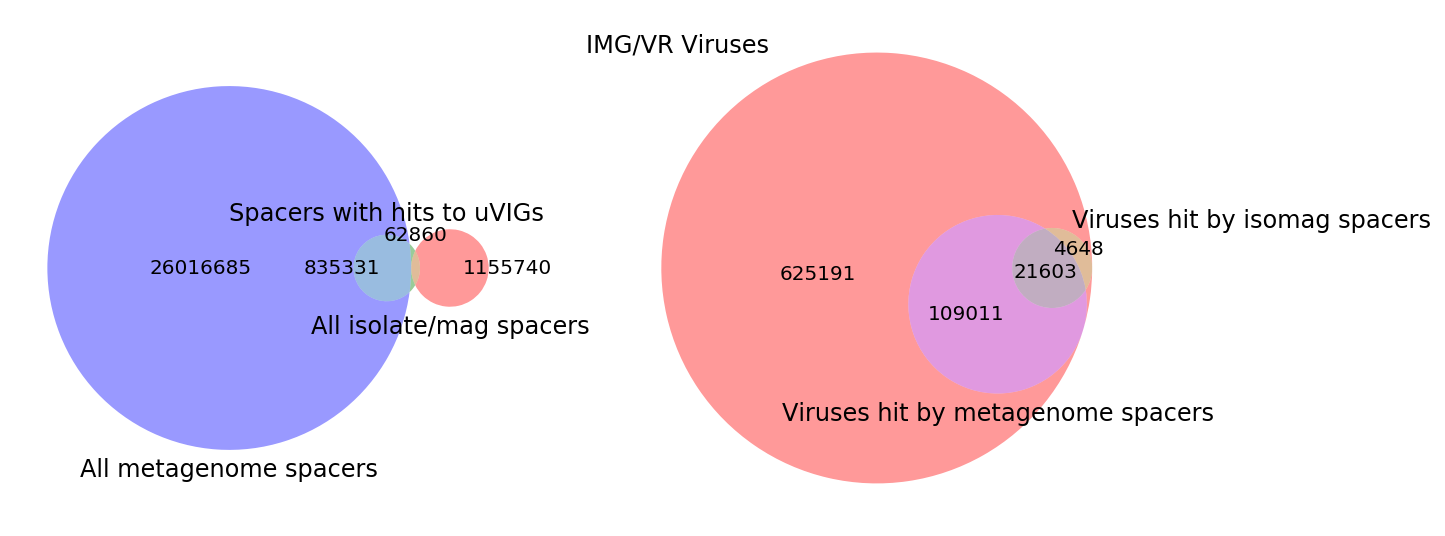

In [64]:
from matplotlib_venn import venn2, venn3

figure( figsize=(10,20) )

subplot( 1,2,1 )

vd1 = venn3( [ set(isomagspacer_records),
               set(isomags.query_id) | set(metaspacers.query_id),
               set(metaspacer_records) ],
              set_labels=[ 'All isolate/mag spacers',
                           'Spacers with hits to uVIGs',
                           'All metagenome spacers' ] )

vd1.hide_zeroes()

vd1.get_label_by_id( '100' ).set_x(0.8)
vd1.get_label_by_id( '110' ).set_y(0.1)
vd1.get_label_by_id( '011' ).set_x(0.3)

vd1.get_label_by_id( 'B'   ).set_y(0.2)

subplot( 1,2,2 )

venn3( [ set( imgvr_records ),
         set( isomags.subject_id ),
         set( metaspacers.subject_id ) ],
       set_labels=[ 'IMG/VR Viruses',
                    'Viruses hit by isomag spacers',
                    'Viruses hit by metagenome spacers' ] )

In [56]:
vd1.

{'10': 0,
 '01': 1,
 '11': 2,
 '100': 0,
 '010': 1,
 '110': 2,
 '001': 3,
 '101': 4,
 '011': 5,
 '111': 6,
 'A': 0,
 'B': 1,
 'C': 2}

In [66]:
isomags['source'] = 'isomag'
metaspacers['source'] = 'metagenome'

allspacers = isomags.append(metaspacers)

clusters = metadata[ [ 'UViG', 'VIRAL_CLUSTERS', 'Habitat' ] ].drop_duplicates()
clusters.columns = [ 'subject_id', 'vcluster', 'vhabitat' ]

allspacers = pandas.merge( allspacers, clusters, on='subject_id', how='left' )

print( 'unique viruses       :', len(set(allspacers.subject_id)) )
print( 'hits to viruses      :', len(allspacers.subject_id))
print( 'isolates + MAGs      :', len(isomagspacer_records) )
print( 'isolates + MAGs hits :', isomags.shape[0] )
print( 'metaspacers          :', len(metaspacer_records) )
print( 'metaspacers hits     :', metaspacers.shape[0] )
print( 'all spacers          :', len(isomagspacer_records) + len(metaspacer_records) )
print( 'isomag + m.g. hits   :', isomags.shape[0] + metaspacers.shape[0] )
print( 'all hits             :', allspacers.shape[0] )

unique viruses       : 135262
hits to viruses      : 6030340
isolates + MAGs      : 1218600
isolates + MAGs hits : 269944
metaspacers          : 26852016
metaspacers hits     : 5760396
all spacers          : 28070616
isomag + m.g. hits   : 6030340
all hits             : 6030340


In [67]:
allspacers.head()

,alignment_length,bitscore,evalue,gap_opens,identity,mismatches,q_end,q_start,query_id,query_length,raw_score,s_end,s_start,source,subject_id,subject_length,vcluster,vhabitat
0,34,55.3,1.400000e-08,0,100.00,0,1,34,637000024:NC_003228:2:2998261,34,34.0,22474,22441,isomag,7000000526_____SRS019397_WUGC_scaffold_4145,47940,sg_282454,host-associated(human)
1,34,52.2,2.500000e-07,0,97.06,1,34,1,637000024:NC_003228:2:2998455,34,32.0,22688,22655,isomag,7000000526_____SRS019397_WUGC_scaffold_4145,47940,sg_282454,host-associated(human)
2,30,45.9,3.200000e-05,0,96.67,1,1,30,637000024:NC_003228:3:4661323,30,28.0,1426,1397,isomag,3300007975_____Ga0114169_100414,20299,vc_2067,host-associated(human)
3,30,45.9,3.200000e-05,0,96.67,1,30,1,637000024:NC_003228:3:4661323,30,28.0,29115,29086,isomag,7000000131_____C1053521,30419,vc_2067,host-associated(human)
4,30,49.0,1.800000e-06,0,100.00,0,1,30,637000024:NC_003228:3:4661400,30,30.0,44901,44872,isomag,3300006487_____Ga0100256_10099,60085,vc_7219,host-associated(human)


In [69]:
from networkx.readwrite import json_graph
import json

# build spacer-virus alignment graph,
# edge attributes are the coordinates of
# spacer alignment on the viral scaffold

print( 'building network...' )
G = networkx.convert_matrix.from_pandas_edgelist( allspacers,
                                                  'query_id',
                                                  'subject_id',
                                                  edge_attr=['s_start', 's_end'] )

print( 'labeling nodes by data source...' )
networkx.set_node_attributes( G, { query_id : { 'source' : source }
                                   for n,(query_id,source)
                                   in allspacers[ [ 'query_id', 'source' ] ].drop_duplicates().iterrows() } )

print( 'labeling nodes by type...' )
networkx.set_node_attributes( G, { subject_id : { 'type' : 'virus' }
                                   for subject_id
                                   in allspacers[ 'subject_id' ].drop_duplicates() } )

print( 'labeling viral nodes...' )
networkx.set_node_attributes( G, { subject_id : { 'vcluster' : vcluster,
                                                  'habitat'  : vhabitat,
                                                  'length'   : vlength }
                                   for n,(subject_id, vlength, vcluster, vhabitat)
                                   in allspacers[ [ 'subject_id',
                                                    'subject_length',
                                                    'vcluster',
                                                    'vhabitat' ] ].drop_duplicates().iterrows() } )

print( 'labeling spacers nodes...' )
networkx.set_node_attributes( G, { query_id : { 'type' : 'spacer' }
                                   for query_id
                                   in allspacers[ 'query_id' ].drop_duplicates() } )

networkx.set_node_attributes( G, { query_id : { 'array' : ':'.join(query_id.split(':')[:3]) }
                                   for query_id
                                   in allspacers[ 'query_id' ].drop_duplicates() } )

networkx.set_node_attributes( G, { query_id : { 'contig' : ':'.join(query_id.split(':')[:2]) }
                                   for query_id
                                   in allspacers[ 'query_id' ].drop_duplicates() } )

networkx.set_node_attributes( G, { query_id : { 'taxon' : ':'.join(query_id.split(':')[:1]) }
                                   for query_id
                                   in allspacers[ 'query_id' ].drop_duplicates() } )

# save graph data
print( 'writing graph data...' )
networkx.write_graphml( G, 'data/viralnet.graphml' )

with open( 'data/viralnet.json', 'w' ) as f :
    json.dump( json_graph.node_link_data( G ), f )

# decompose graph into connected component subgraphs
print( 'extracting connected components...' )
components = sorted( networkx.connected_component_subgraphs(G), key=len, reverse=True )

building network...
labeling nodes by data source...
labeling nodes by type...
labeling viral nodes...
labeling spacers nodes...
writing graph data...
extracting connected components...


In [70]:
from itertools import combinations

def collapse_to_viruses( g ) :
    viral_edgelist = {}
    viral_nodedata = {}
    for node, node_attributes in g.nodes.data() :
        if node_attributes['type'] == 'virus' :
            viral_nodedata[ node ] = node_attributes
        if node_attributes['type'] == 'spacer' :
            viruses = list( g.neighbors(node) )
            # spacers can only be connected to viruses, and spacers
            # that hit only one virus don't add any infomrmation
            if len(viruses) == 1 : continue
            for a,b in combinations( viruses, 2 ) :
                key = ':::'.join( sorted( [a,b] ) )
                if not key in viral_edgelist :
                    viral_edgelist[key] = 1
                else :
                    viral_edgelist[key] = viral_edgelist[key] + 1
    
    g1 = networkx.Graph()
    g1.add_weighted_edges_from( [ key.split(':::') + [value]
                                  for key,value
                                  in viral_edgelist.items() ] )
        
    # there has got to be a better way to do this
    for node, node_attributes in viral_nodedata.items() :
        for key,value in node_attributes.items() :
            g1.node[node][key] = value

    return( g1 )

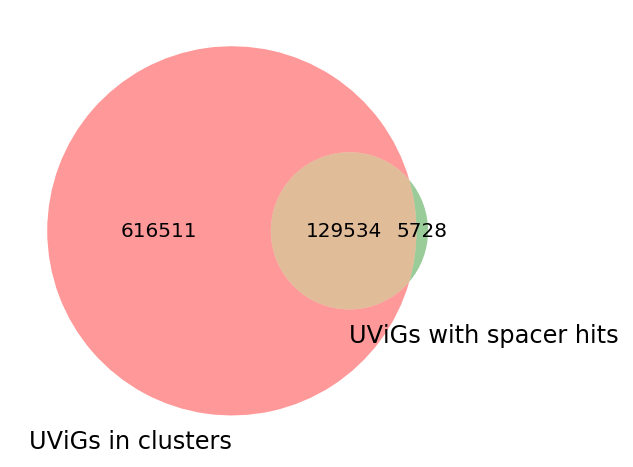

In [71]:
#g1.nodes.data()

#allspacers[ allspacers.subject_id == '3300001340_____JGI20133J14441_1001514' ]

venn2( ( set(metadata.UViG.drop_duplicates()), 
         set(allspacers.subject_id.drop_duplicates()) ),
       set_labels=[ 'UViGs in clusters', 
                    'UViGs with spacer hits' ] )

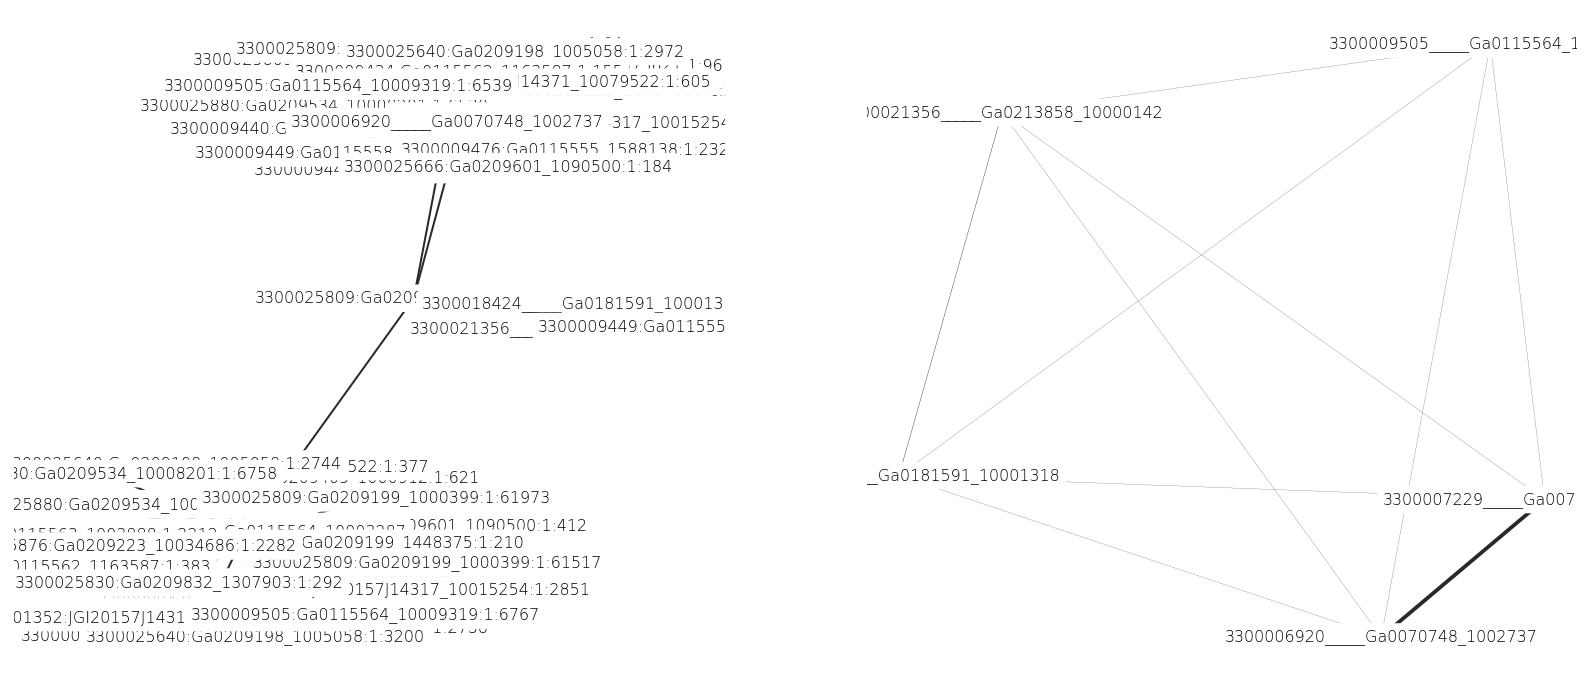

In [76]:
# Code cell for plotting an individual network

from grave import plot_network, use_attributes

colormap = matplotlib.cm.Dark2
n = 1600

figure( figsize = ( 14, 6 ) )

#def edge_style(edge_attrs) :
#    alpha = edge_attrs['weight'] / 1000
#    return {'color' : 'black', 'alpha' : alpha }

def edge_style( edge_attributes ) :
    return { 'linewidth' : edge_attributes['weight'] / 1000 }

def node_style( node_attributes ) :
    return { 'label' : node_attributes.get( 'label' ) }

def font_styler( attributes ) :
    return { 'font_size'   : 8,
             'font_weight' : .5,
             'font_color'  : 'k' }

for n,g in enumerate( [ components[n], collapse_to_viruses( components[ n ] ) ] ) :
    subplot( 1, 2, n+1 )

    centrality = networkx.closeness_centrality( g )
    max_centrality = max( centrality.values() )
    
    for node, node_attributes in g.nodes.data() :
        node_attributes['size'] = log( ( max_centrality / centrality[node] ) + .1 )
        if node_attributes['type'] == 'spacer' :
            node_attributes['shape'] = 's'
            #node_attributes['color'] = taxa_colors[ component_taxa[n][node] ]
            if node_attributes['source'] == 'isomag' :
                node_attributes['color'] = 'blue'
            else :
                node_attributes['color'] = 'red'
            node_attributes['label'] = 1
        
    for u, v, edge_attributes in g.edges.data():
        #color_idx = ( 0.75 * edge_attributes['bitscore'] / bit_med )
        #cmap = get_cmap()
        #edge_attributes['color'] = cmap(color_idx)
        if 'weight' in edge_attributes :
            edge_attributes['width'] = edge_attributes['weight'] /10
        else :
            edge_attributes['width'] = 1
            
    plt = plot_network( g, layout='spring',
                        node_style=use_attributes( [ 'label', 'color', 'shape' ] ),
                        node_label_style=font_styler,
                        edge_style=use_attributes() )

In [75]:
def network_summary( g ) :
    print( 'nodes               :', len( g ) )
    print( 'edges (full graph)  :', len( g.edges ) )
    print( 'edges (viral graph) :', len( collapse_to_viruses( g ).edges ) ) 
    print( 'UViGs               :', len( [ (node,data) for node,data in g.node.data() if data['type'] == 'virus' ] ) )
    print( 'viral clusters      :', len( set( data['vcluster'] for node,data in g.node.data() if data['type'] == 'virus' ) ) )
    print( 'viral habitats      :', len( set( data['habitat'] for node,data in g.node.data() if data['type'] == 'virus' ) ) )
    print( 'all spacers         :', len( [ (node,data) for node,data in g.node.data() if data['type'] == 'spacer' ] ) )
    print( 'metagenome spacers  :', len( [ (node,data) for node,data in g.node.data() if data['type'] == 'spacer' and data['source'] == 'metagenome' ] ) )
    print( 'isolate/MAG spacers :', len( [ (node,data) for node,data in g.node.data() if data['type'] == 'spacer' and data['source'] == 'isomag' ] ) )    
    
network_summary( components[10] )

nodes               : 3034
edges (full graph)  : 13806
edges (viral graph) : 460
UViGs               : 80
viral clusters      : 14
viral habitats      : 2
all spacers         : 2954
metagenome spacers  : 2953
isolate/MAG spacers : 1


In [109]:
[ data['vcluster'] for node,data in g.node.data() if data['type'] == 'virus' ]

['sg_249941', 'sg_249947']

In [37]:
CRISPR_taxon = allspacers[ ['CRISPR_array', 'Host_Phylum' ] ].drop_duplicates()
CRISPR_taxon = { key : value for n,(key,value) in CRISPR_taxon.iterrows() }

progbar = pyprind.ProgBar( len(components), title='counting component taxa...' )
component_taxa = []
for n,g in enumerate( components ) :
    
    #centrality = networkx.closeness_centrality( g )
    #max_centrality = max( centrality.values() )
    
    taxa = {}
    for node, node_attributes in g.nodes.data() :
        if node_attributes['type'] == 'CRISPR_array' :
            taxa[node] = CRISPR_taxon[node]
    
    component_taxa.append( taxa )
    
    progbar.update()

bit_min = min( allspacers['bitscore'] )
bit_max = max( allspacers['bitscore'] )
bit_med = median( allspacers['bitscore'] )

pandas.DataFrame.describe( allspacers['bitscore'] )

counting component taxa...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


count    1.053919e+07
mean     5.261946e+01
std      4.855740e+00
min      4.270000e+01
25%      4.900000e+01
50%      5.220000e+01
75%      5.690000e+01
max      1.550000e+02
Name: bitscore, dtype: float64

No handles with labels found to put in legend.


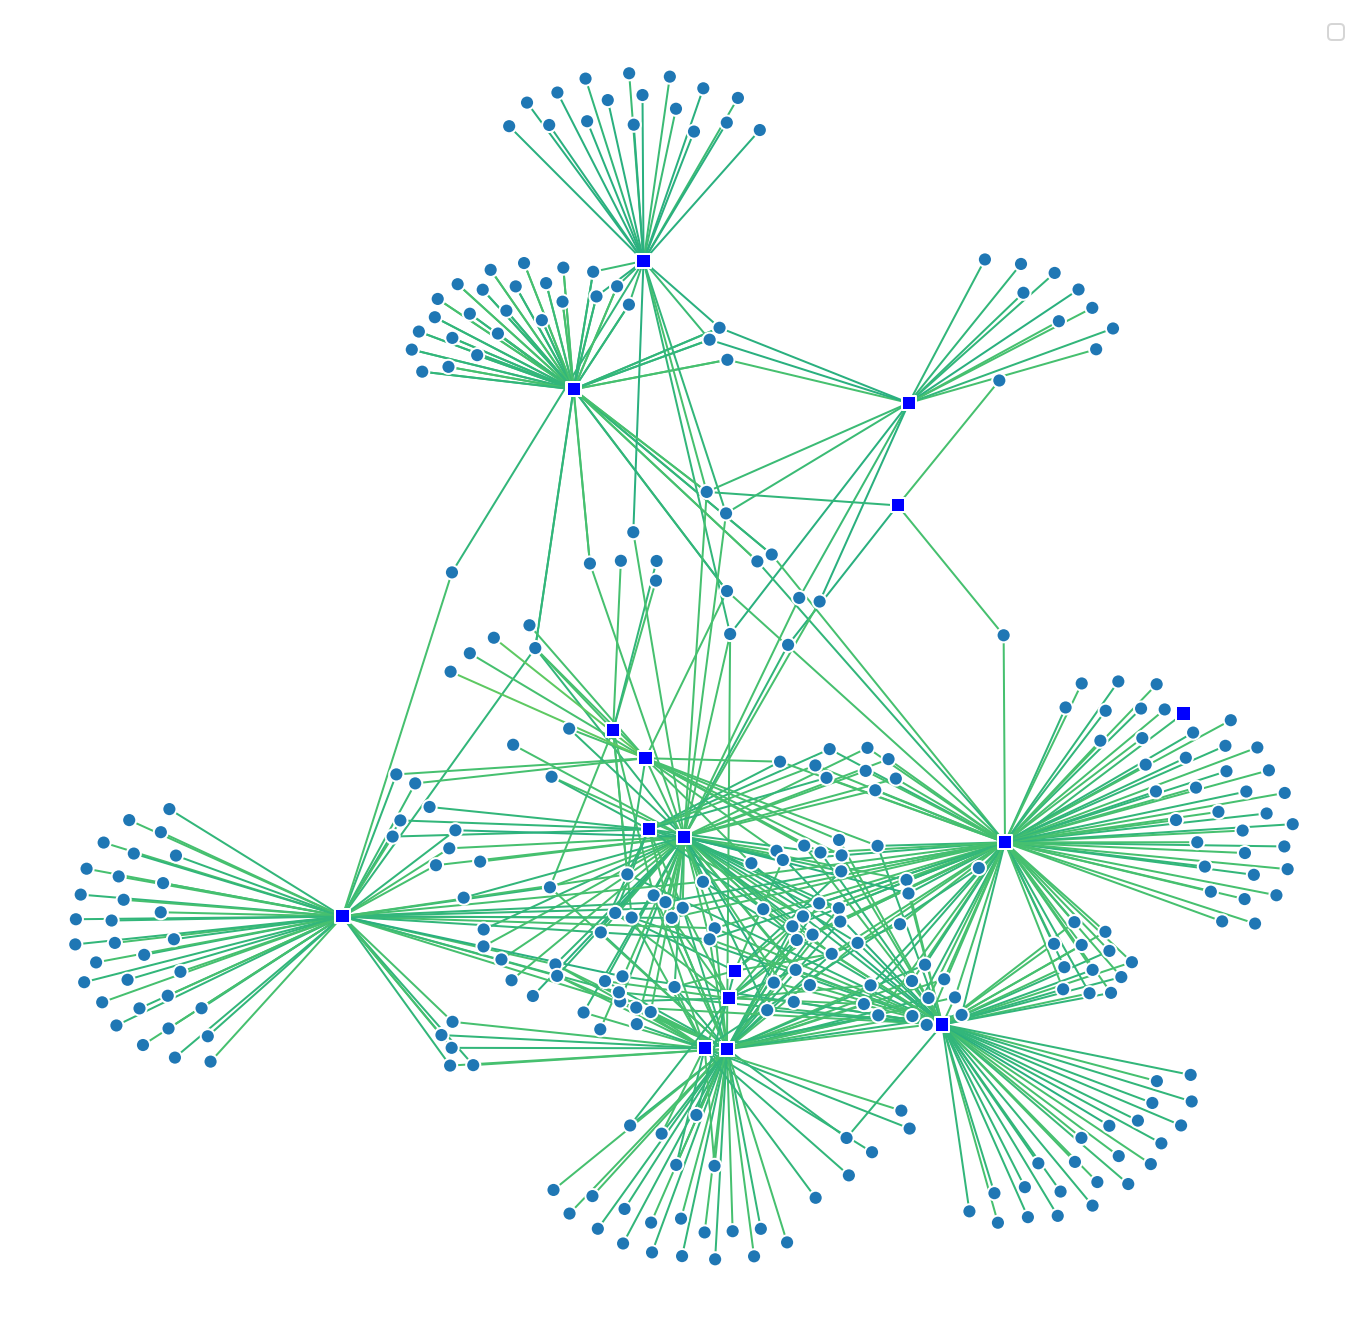

In [43]:
# Code cell for plotting an individual network

from grave import plot_network, use_attributes

colormap = matplotlib.cm.Dark2
n = 2

figure( figsize = ( 12, 12 ) )

#def edge_style(edge_attrs) :
#    alpha = edge_attrs['weight'] / 1000
#    return {'color' : 'black', 'alpha' : alpha }

def edge_style( edge_attributes ) :
    return { 'linewidth' : edge_attributes.get( 'bitscore', 1 ) }

def node_style( node_attributes ) :
    return { 'label' : node_attributes.get( 'label' ) }

g = components[ n ]

centrality = networkx.closeness_centrality( g )
max_centrality = max( centrality.values() )

taxa = set( component_taxa[n].values() )
taxa_colors = { taxon : color for taxon, color in zip( taxa, colormap.colors[:len(taxa)] ) }

for node, node_attributes in g.nodes.data():
    node_attributes['size'] = ( ( max_centrality / centrality[node] ) + .1 ) * 30
    if node_attributes['type'] == 'CRISPR_array' :
        node_attributes['shape'] = 's'
        #node_attributes['color'] = taxa_colors[ component_taxa[n][node] ]
        if node_attributes['source'] == 'isomag' :
            node_attributes['color'] = 'blue'
        else :
            node_attributes['color'] = 'red'
        node_attributes['label'] = component_taxa[n][node]

for u, v, edge_attributes in g.edges.data():
    color_idx = ( 0.75 * edge_attributes['bitscore'] / bit_med )
    cmap = get_cmap()
    edge_attributes['color'] = cmap(color_idx)
    edge_attributes['width'] = 2
    
plt = plot_network( g, layout='spring',
              node_style=use_attributes( [ 'label', 'color', 'shape' ] ),
              edge_style=use_attributes('color') )

legend()

In [49]:
len(components)


1216